In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
sns.set(rc={'figure.figsize':(12, 4)})

In [13]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'], format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
date = data["Date"]
data = data.set_index('Date')
data.Energy_Generated=pd.to_numeric(data.Energy_Generated)
data

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2013-01-01,1013,0.938,998,0,807,13:10,Showers,8,13,NaN,NaN,NaN,NaN,3458
2013-01-02,2878,2.665,2840,0,837,13:00,Mostly Cloudy,7,13,NaN,NaN,NaN,NaN,3472
2013-01-03,3282,3.039,2844,0,708,12:40,Mostly Cloudy,2,14,NaN,NaN,NaN,NaN,3486
2013-01-04,3377,3.127,3332,0,682,13:00,Mostly Cloudy,2,15,NaN,NaN,NaN,NaN,3502
2013-01-05,3315,3.069,2735,0,710,13:00,Mostly Cloudy,3,11,NaN,NaN,NaN,NaN,3518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-25,3144,2.911,2977,0,984,13:20,Partly Cloudy,9,22,NaN,NaN,NaN,NaN,6308
2019-04-26,2715,2.514,2399,0,985,16:40,Partly Cloudy,3,17,NaN,NaN,NaN,NaN,6315
2019-04-27,2477,2.294,2049,0,1041,15:40,Partly Cloudy,7,20,NaN,NaN,NaN,NaN,6323


In [14]:
conditions = data.Condition.values
print(np.unique(conditions))

['Cloudy' 'Fine' 'Mostly Cloudy' 'Not Sure' 'Partly Cloudy' 'Showers']


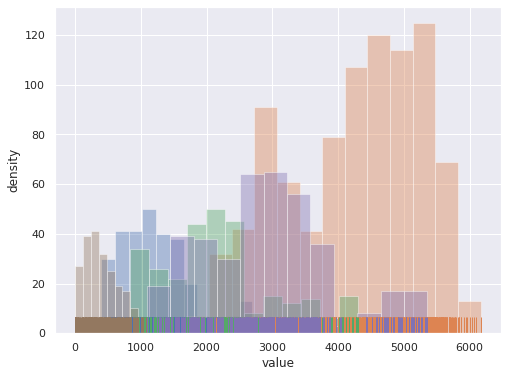

In [15]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
fig, ax = plt.subplots(figsize=(8,6))
for label in np.unique(conditions):
    # this is to plot the kde
    try:
        sns.distplot(train_data.Energy_Generated[train_data.Condition == label],label=label,kde=False, rug=True)
    except:
        print(label)
#sns.kdeplot(train_data.Energy_Generated[train_data.Condition == 'Fine'],label='Fine')
#sns.distplot(train_data.Energy_Generated[train_data.Condition == 'Fine'],label='Fine',kde=False, rug=True)
#sns.kdeplot(data.Energy_Generated)
plt.xlabel('value')
plt.ylabel('density')
plt.show()


In [25]:

# split into samples
n_steps = 28
transformed_data = torch.FloatTensor(transformed_data).view(-1)
#X, y = split_sequence(daily_data, n_steps)
train_inout_seq = create_inout_sequences(transformed_data, n_steps)
# summarize the data
#for i in range(len(X)):
    #print(X[i], y[i])

**MV LSTM**

In [67]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [68]:
#daily_data_with_weather = train_data[['Condition','Min_Temperature','Max_Temperature','Energy_Generated']]
features = ['Condition','Energy_Generated']
daily_data_with_weather = data[features]
conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.Condition = encoder.fit_transform(daily_data_with_weather.Condition)
conditions_labels = set(daily_data_with_weather['Condition'])

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

daily_data_with_weather = daily_data_with_weather[daily_data_with_weather.Condition != 3]


train_size = int(len(daily_data_with_weather) * 0.8)
test_size = len(daily_data_with_weather) - train_size
print(train_size,test_size)
# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')

#daily_data_with_weather['Energy_Generated_x'] = daily_data_with_weather.Energy_Generated.shift(1)
#daily_data_with_weather['Energy_Generated_x'] = daily_data_with_weather.Energy_Generated
daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#daily_data_with_weather = daily_data_with_weather[cols]

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(daily_data_with_weather.iloc[:train_size])
scaled = scaler.transform(daily_data_with_weather)
print(scaled)

{'Cloudy': 0, 'Fine': 1, 'Mostly Cloudy': 2, 'Not Sure': 3, 'Partly Cloudy': 4, 'Showers': 5}
1768 442
[[1.         0.16336796]
 [0.4        0.4659312 ]
 [0.4        0.53147304]
 ...
 [0.8        0.40087605]
 [0.2        0.61356264]
 [0.8        0.52871513]]


/home/zhe/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [69]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [70]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 90 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(scaled, n_timesteps)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:] 
# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1,weight_decay=0.001)
train_episodes = 400
batch_size = 128

In [71]:
print(len(y_train))

1768


In [72]:
trainX = Variable(torch.Tensor(X_train))
trainY = Variable(torch.Tensor(y_train))

testX = Variable(torch.Tensor(X_test))
testY = Variable(torch.Tensor(y_test))
print(trainY)

tensor([0.3274, 0.3452, 0.9064,  ..., 0.8561, 0.1559, 0.2180])


In [73]:
loss_values = []
val_loss_values = []
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
        
    
    loss_values.append(loss)
        
    ##add test
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX)
    loss = criterion(test_predict.view(-1), testY)  
    val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss))   

/home/zhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/zhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


0, loss 13.076496 val_loss 1.464813
10, loss 0.052113 val_loss 0.071349
20, loss 0.046105 val_loss 0.058793
30, loss 0.040471 val_loss 0.048196
40, loss 0.038786 val_loss 0.039239
50, loss 0.051259 val_loss 0.033264
60, loss 0.122890 val_loss 0.079870
70, loss 0.027025 val_loss 0.021037
80, loss 0.029142 val_loss 0.008377
90, loss 0.045973 val_loss 0.007218
100, loss 0.026359 val_loss 0.018398
110, loss 0.016344 val_loss 0.003670
120, loss 0.016965 val_loss 0.001032
130, loss 0.029712 val_loss 0.001717
140, loss 0.030857 val_loss 0.012700
150, loss 0.012740 val_loss 0.002728
160, loss 0.009268 val_loss 0.000442
170, loss 0.007866 val_loss 0.001780
180, loss 0.008269 val_loss 0.003559
190, loss 0.010958 val_loss 0.005051
200, loss 0.032423 val_loss 0.003178
210, loss 0.002495 val_loss 0.002399
220, loss 0.005478 val_loss 0.001157
230, loss 0.007535 val_loss 0.000263
240, loss 0.013928 val_loss 0.000976
250, loss 0.041854 val_loss 0.001558
260, loss 0.002605 val_loss 0.000603
270, loss 0

In [103]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(daily_data_with_weather.iloc[:train_size].Energy_Generated.values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [106]:
mv_net.init_hidden(testX.size(0))
test_predict = mv_net(testX).detach().numpy()
print(test_predict.shape)

(352, 1)


In [107]:
#test_predict = np.c_[ test_predict.detach().numpy(), np.zeros(testX.shape[0]) ]
test_predict = target_scaler.inverse_transform(test_predict.reshape(-1, 1))
#print(test_predict)
#print(daily_data_with_weather['Energy_Generated'].iloc[train_size + 90::1].shape)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_predict[:,0],daily_data_with_weather['Energy_Generated'].iloc[train_size + 90::1] ,squared=False)
print("RMSE = %d" % rmse) 

RMSE = 1686


(1768, 1)
(1768,)


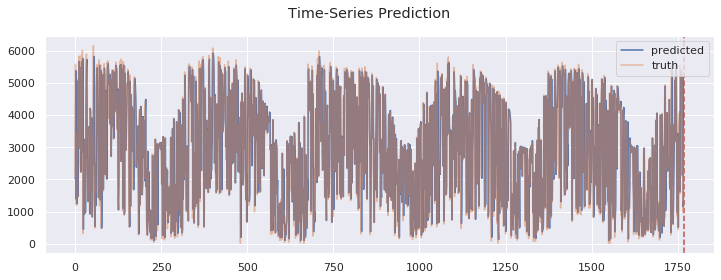

In [122]:
mv_net.eval()
mv_net.init_hidden(trainX.size(0))
train_predict = mv_net(trainX)
train_predict = train_predict.data.numpy()
print(train_predict.shape)

train_truth = daily_data_with_weather['Energy_Generated'].iloc[90:train_size + 90:1]
print(train_truth.shape)
train_predict = target_scaler.inverse_transform(train_predict.reshape(-1,1))
#print(train_predict[:,0])
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(train_predict[:,0], label="predicted")
plt.plot(train_truth.values, alpha=0.5, label="truth")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

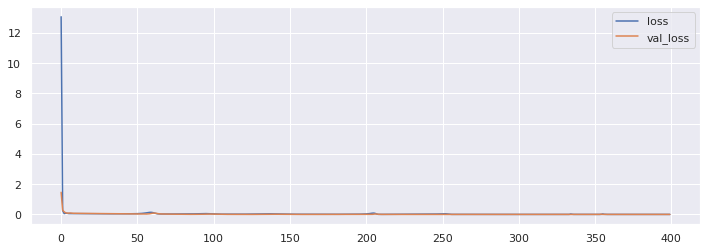

In [76]:
plt.plot(loss_values[:], label="loss")
plt.plot(val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

<Figure size 864x288 with 0 Axes>

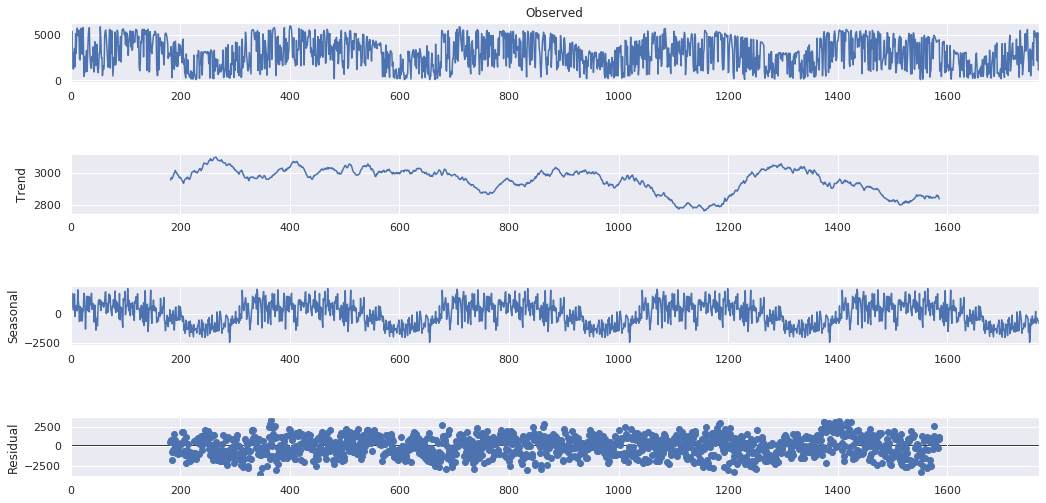

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_predict[:,0],period=365) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

mean = 8.022363
std  = 1722.4822
7.9194336
0.8101725685783476


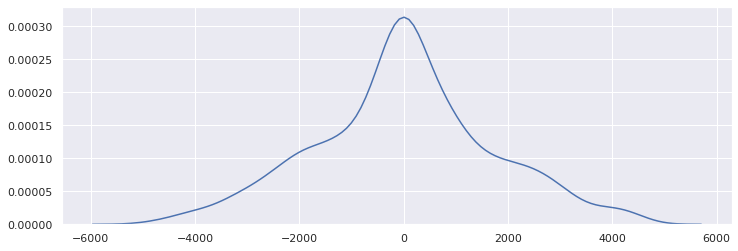

In [124]:

residuals = train_predict[:,0] - train_truth.values
sns.kdeplot(residuals)
print("mean =", np.mean(residuals))
print("std  =", np.std(residuals))
print(np.median(residuals))
from scipy import stats
k2, p  = stats.normaltest(residuals)
print(p)

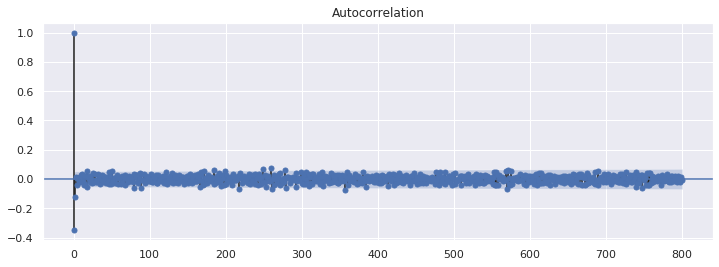

In [125]:
import statsmodels.api as sm
acf = sm.graphics.tsa.plot_acf(residuals, lags=800)

In [127]:
from scipy import stats
alpha = 0.05

df = daily_data_with_weather.copy()
df = df.iloc[n_timesteps:]
df = df.reset_index()

print("Total RMSE = %d \n" % rmse) 

for c, c_label in zip(conditions, conditions_labels):
    print(c_label)
    if(c_label != 3):
        # Select indices corresponding to condition
        condition_indices = df[df['Condition']==c_label].index.values
        target = [dataY[:,0][i] for i in condition_indices]
        predicted = [data_predict[:,0][i] for i in condition_indices]

        # Study residuals
        residuals = np.array(target) - np.array(predicted)
        sns.kdeplot(residuals, label=c_label)
        c_residual_mean = np.mean(residuals)
        k2, p  = stats.normaltest(residuals)
        print(p)
        normal = "(non-normal)" if p < alpha else ""

        # Compute rmse score
        c_rmse = mean_squared_error(target,predicted,squared=False)

        print("%s (%d) : \n\t RMSE = %d, r_mean = %d %s" % (c, len(condition_indices), c_rmse, c_residual_mean, normal)) 

    
plt.legend()
plt.title("Distribution of residuals per weather condition")
plt.show()

Total RMSE = 1686 

0


IndexError: index 1768 is out of bounds for axis 0 with size 1768

# Bayesian LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class BayesianLSTM(nn.Module):

    def __init__(self, n_features, output_length):

        super(BayesianLSTM, self).__init__()

        self.hidden_size_1 = 128
        self.hidden_size_2 = 32
        self.n_layers = 1 # number of (stacked) LSTM layers

        self.lstm1 = nn.LSTM(n_features, 
                             self.hidden_size_1, 
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=1,
                             batch_first=True)
        
        self.dense = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)
        output, _ = self.lstm1(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=0.5, training=True)
        output = self.dense(state[0].squeeze(0))
        
        return output
        
    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state
    
    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()t